<div style="font-size:30pt; line-height:25pt; font-weight:bold; text-align:center;">When, where and how to add new neurons to ANNs </div>

# Introduction

Neural networks have come a long way, especially deep models with lots of neurons. Most of these models have a fixed structure, meaning we decide on the number of neurons in each layer before training and then tweak the parameters based on the dataset.

However, there's a new approach in deep learning that's all about **dynamic networks**. Unlike the fixed ones, dynamic networks not only learn parameters during training but can also change their structure as they learn.

This shift to dynamic networks has some advantages. It makes training more efficient and eliminates the need for manual tweaking of architectures. Dynamic networks can adapt to new information and tasks easily. They can even add or remove parts like neurons and connections as needed.

This notebook is about understanding dynamic networks, focusing on a specific idea called **structural pruning**. This process involves selectively removing connections or neurons, showing a bit of a concept called neurogenesis. Neurogenesis is like adding new elements within existing layers. Structural pruning, as you'll see in this notebook, is an example that highlights how dynamic networks can keep evolving and improving.

# Artificial Neural Networks (ANNs)

First, let's make a short reminder about Artificial Neural Networks.

Artificial Neural Networks (ANNs) represent a class of computational models inspired by the neural architecture of the human brain. Operating as interconnected nodes organized into layers, ANNs leverage a combination of linear and non-linear transformations to capture complex relationships within data.

At their core, ANNs consist of an input layer, one or more hidden layers, and an output layer. Each connection between nodes is associated with a weight, and the network learns by adjusting these weights during a training phase. The training process involves minimizing a predefined loss function, typically through optimization algorithms like stochastic gradient descent (SGD).

Activation functions introduce non-linearities into the network, enabling the modeling of intricate mappings between inputs and outputs. Common activation functions include Rectified Linear Units (ReLU), Sigmoid, and Hyperbolic Tangent (tanh), each influencing the network's capacity to capture and propagate information through the layers..

Training large-scale ANNs requires careful consideration of hyperparameters, such as learning rates, batch sizes, and regularization techniques to prevent overfitting.

You can find more information and detail on **[this github](https://github.com/SupaeroDataScience/deep-learning)**

<center><img src="img\ann.png" width="600px"></img></center>

## Time to code !! ##

Let's make a little ANN to classify the **[MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database)**. The MNIST dataset is composed of a collection of handwritten digit images, MNIST stands as a foundational resource for training and evaluating algorithms designed to recognize and classify digits from 0 to 9.
Each image in the MNIST dataset is a grayscale, 28x28-pixel representation of a handwritten digit.

**We will use Pytorch but you can do the same thing with Keras**

First, let's load the data and print 9 random figures :

In [4]:
# Import the necessary libraries

import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import os
from tqdm import tqdm
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from torch import nn, optim



  Using cached pyarrow-15.0.0-cp311-cp311-win_amd64.whl.metadata (3.1 kB)
Using cached pyarrow-15.0.0-cp311-cp311-win_amd64.whl (24.8 MB)


In [5]:
# We need a, image transform to convert to Tensor and normalize with a mean of 0.5 and standard deviation of 0.5
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
    ])

# Download the Train and Test set

trainset = datasets.MNIST('.', train=True, download=True, transform=transform)
testset = datasets.MNIST('.', train=False, download=True, transform=transform)

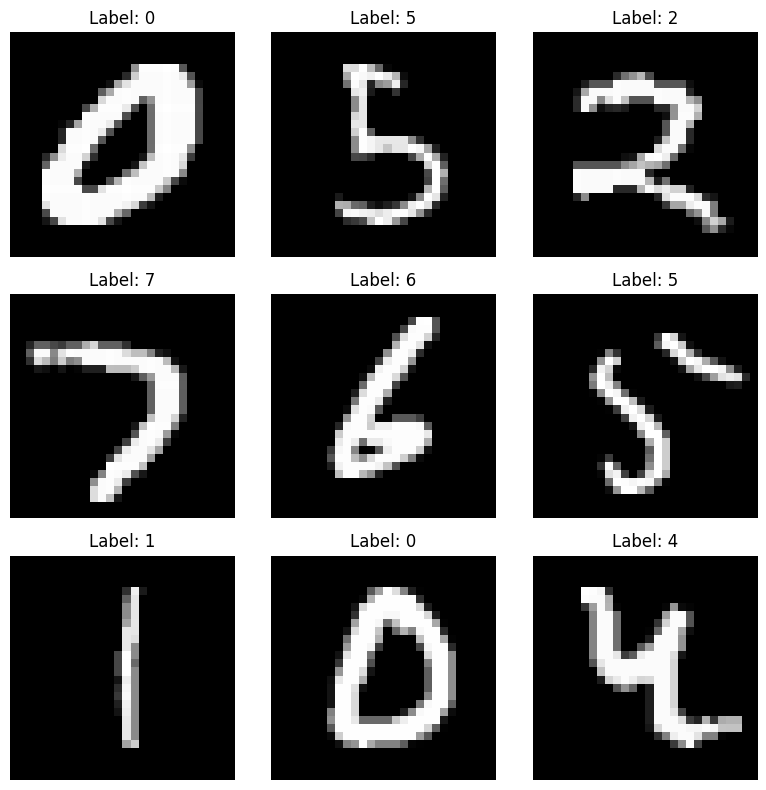

In [6]:
# Set up a 3x3 grid for displaying the images
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
axes = axes.flatten()

# Get 9 random indices from the training set
random_indices = np.random.choice(len(trainset), size=9, replace=False)

# Display the 9 random images
for i, idx in enumerate(random_indices):
    image, label = trainset[idx]
    image = image.numpy().squeeze()
    
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(f"Label: {label}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [7]:
# Parameters for the dataloader
batch_size = 64
valid_size = 0.2

In [8]:
# Split the training set into training and validation sets
num_train = len(trainset)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# Define the samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [9]:
# Create the dataloaders
train_loader = DataLoader(trainset, batch_size=batch_size, sampler=train_sampler)
valid_loader = DataLoader(trainset, batch_size=batch_size, sampler=valid_sampler)

Now that we have prepared the data, we can implement a little ANN, with 2 hidden layers to classify the figures.

In [10]:
# Parameters for the model
nb_epochs = 10
lr = 0.001

In [28]:
# Model architecture of the neural network fully connected

class ANN(nn.Module):
    def __init__(self, input_size, output_size, hidden_layer_1, hidden_layer_2, hidden_layer_3):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, hidden_layer_1, bias=False), 
            nn.ReLU(),
            nn.Linear(hidden_layer_1, hidden_layer_2, bias=False),
            nn.ReLU(),
            nn.Linear(hidden_layer_2, hidden_layer_3, bias=False),
            nn.ReLU(),
            nn.Linear(hidden_layer_3, output_size, bias=False),
            nn.LogSoftmax(dim=1))
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        return self.network(x)

# Create the model
input_size = 28*28
output_size = 10
hidden_layer_1 = 512
hidden_layer_2 = 512
hidden_layer_3 = 512

model_ann = ANN(input_size, output_size, hidden_layer_1, hidden_layer_2, hidden_layer_3)

# Define the loss function and the optimizer
criterion = nn.NLLLoss()
optimizer = optim.Adam(model_ann.parameters(), lr=lr)
print(model_ann)

ANN(
  (network): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=False)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=False)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=512, bias=False)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=10, bias=False)
    (7): LogSoftmax(dim=1)
  )
)


In [29]:
# Train the model
list_loss = []
for i in tqdm(range(nb_epochs),desc="Training of the ANN"):
    model_ann.train()
    running_loss = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        output = model_ann(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        # print(loss)
    list_loss.append(running_loss/len(train_loader))
    
    # print(f"Epoch nb {i+1}. Training loss: {running_loss/len(train_loader)}")

Training of the ANN: 100%|██████████| 10/10 [09:51<00:00, 59.15s/it] 


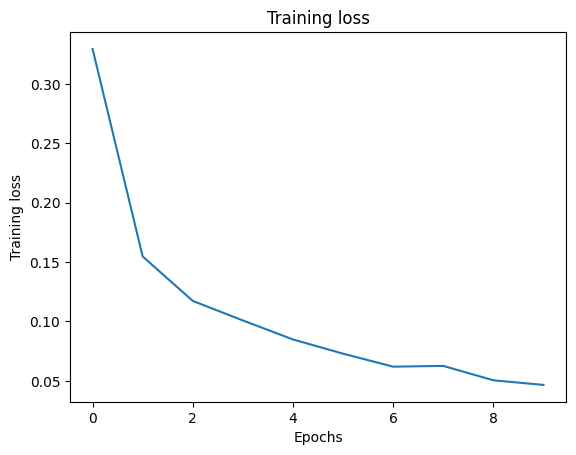

In [30]:
# Plot the training loss
plt.plot(list_loss)
plt.xlabel('Epochs')
plt.ylabel('Training loss')
plt.title('Training loss')
plt.show()

In [31]:
# Test the model
model_ann.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in valid_loader:
        output = model_ann(images)
        _, predicted = torch.max(output, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
torch.save(model_ann.state_dict(), 'model.pt')
print(f"Accuracy of the model on the validation set: {100 * correct / total:.2f}%")

Accuracy of the model on the validation set: 97.06%


# Structural pruning 

Now that we've established our neural network, consisting of two layers with 512 neurons each, we can explore techniques to prune it effectively. Pruning aims to streamline the network, reducing training and validation time without compromising performance. Among various pruning methods, two stand out as the most commonly used:

1. Weight pruning
2. Neuron pruning

Weight pruning involves removing connections between neurons by setting the corresponding weights to zero. Conversely, neuron pruning entails eliminating entire neurons by zeroing out all connections associated with the neuron being pruned. The distinction between these methods is illustrated in the image below.

<center><img src="img\Pruning image.webp" width="500px"></img></center>

## 1. Weight pruning

In the technique of weight pruning, we selectively remove connections within a neural network by setting individual weights in the weight matrix to zero. This process effectively sparsifies the network, reducing its complexity and potentially improving its efficiency during both training and inference stages.

The mechanism of weight pruning involves ranking the individual weights in the weight matrix $W$ based on their magnitudes, considering the absolute value of each weight. By doing so, we obtain a sorted list of weights, with the smallest magnitudes appearing at the beginning of the list and the largest magnitudes towards the end.

To achieve a desired level of sparsity, denoted as $k\%$, we then proceed to set to zero the smallest $k\%$ of weights from the sorted list. This corresponds to deleting a certain percentage of connections in the neural network, effectively reducing the number of parameters and connections within the model.

The degree of sparsity, represented by $k\%$, can be adjusted based on specific requirements or constraints. Higher values of $k\%$ result in more aggressive pruning, leading to greater sparsity but potentially at the expense of model performance. Conversely, lower values of $k\%$ preserve more connections and parameters, thus retaining more of the network's original capacity.

First let's code a class of pruning. To do so, we will rewrite the code implemented in Pytorch to understand how it works. We will use the useful fonctions and the skeleton class that you can find **[here](https://github.com/pytorch/pytorch/blob/main/torch/nn/utils/prune.py)**. 

In [81]:
# Skeleton of the pruning class
from torch.nn.utils.prune import BasePruningMethod

# Some useful fonction to validate the pruning amount 
# If you want to see how they work, you can look at the link right above
from torch.nn.utils.prune import _validate_pruning_amount_init, _validate_pruning_amount

In [82]:
class Weight_Pruning(BasePruningMethod):
    """Prune (currently unpruned) units in a tensor by zeroing out the ones with the lowest L1-norm.

    Args:
        amount (float): quantity of parameters to prune.
            It should be between 0.0 and 1.0 and represent the
            fraction of parameters to prune.
    """

    PRUNING_TYPE = "unstructured"

    def __init__(self, amount):
        # Check range of validity of pruning amount
        _validate_pruning_amount_init(amount)
        self.amount = amount

    def compute_mask(self, t, default_mask):

        # t is the tensor to prune, meaning the weights of the layer
        # Check that the amount of units to prune is not > than the number of
        # parameters in t
        tensor_size = t.nelement()

        # Compute number of units to prune: amount * tensor_size
        nparams_toprune = round(self.amount * tensor_size)

        # This should raise an error if the number of units to prune is larger
        # than the number of units in the tensor
        _validate_pruning_amount(nparams_toprune, tensor_size)

        mask = default_mask.clone(memory_format=torch.contiguous_format)

        if nparams_toprune != 0:  # k=0 not supported by torch.kthvalue            
            # Prune the smallest k (torch.topk returns the k largest elements of the input tensor)
            # largest=True --> top k; largest=False --> bottom k
            topk = torch.topk(torch.abs(t).view(-1), k=nparams_toprune, largest=False)
            # topk will have .indices and .values
            mask.view(-1)[topk.indices] = 0

        return mask

    @classmethod
    def apply(cls, module, name, amount, importance_scores=None):
        r"""Add pruning on the fly and reparametrization of a tensor.

        Adds the forward pre-hook that enables pruning on the fly and
        the reparametrization of a tensor in terms of the original tensor
        and the pruning mask.

        Args:
            module (nn.Module): module containing the tensor to prune
            name (str): parameter name within ``module`` on which pruning
                will act.
            amount (int or float): quantity of parameters to prune.
                It should be between 0.0 and 1.0 and represent the
                fraction of parameters to prune.
            importance_scores (torch.Tensor): tensor of importance scores (of same
                shape as module parameter) used to compute mask for pruning.
                The values in this tensor indicate the importance of the corresponding
                elements in the parameter being pruned.
                If unspecified or None, the module parameter will be used in its place.
        """
        return super().apply(
            module, name, amount=amount, importance_scores=importance_scores
        )


In [83]:
import torch.nn.utils.prune as prune

list_accuracy_weight = []

for i in tqdm(range(20)):
    model = ANN(input_size, output_size, hidden_layer_1, hidden_layer_2,hidden_layer_3)
    model.load_state_dict(torch.load('model.pt'))
    prune_l1 = Weight_Pruning(amount=i/20)
    for name, module in model.named_modules():
        if isinstance(module, nn.Linear):
            prune_l1.apply(module, name='weight', amount=i/20)

    # Test the model
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in valid_loader:
            output = model(images)
            _, predicted = torch.max(output, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    list_accuracy_weight.append(100 * correct / total)


  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:40<00:00,  2.02s/it]


In [79]:
# Neuron pruning
list_accuracy_neurons = []
parameters_to_prune = (
    (model.network[0], 'weight'),
    (model.network[2], 'weight'),
    (model.network[4], 'weight'),
    (model.network[6], 'weight'),
)

for i in tqdm(range(20)):
    model = ANN(input_size, output_size, hidden_layer_1, hidden_layer_2,hidden_layer_3)
    model.load_state_dict(torch.load('model.pt'))
    prune.global_unstructured(parameters_to_prune, pruning_method=prune.L1Unstructured, amount=i/20)

    # Test the model
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in valid_loader:
            output = model(images)
            _, predicted = torch.max(output, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    list_accuracy_neurons.append(100 * correct / total)
print(list_accuracy_neurons)

100%|██████████| 20/20 [00:37<00:00,  1.89s/it]

[97.05833333333334, 97.05833333333334, 97.05833333333334, 97.05833333333334, 97.05833333333334, 97.05833333333334, 97.05833333333334, 97.05833333333334, 97.05833333333334, 97.05833333333334, 97.05833333333334, 97.05833333333334, 97.05833333333334, 97.05833333333334, 97.05833333333334, 97.05833333333334, 97.05833333333334, 97.05833333333334, 97.05833333333334, 97.05833333333334]


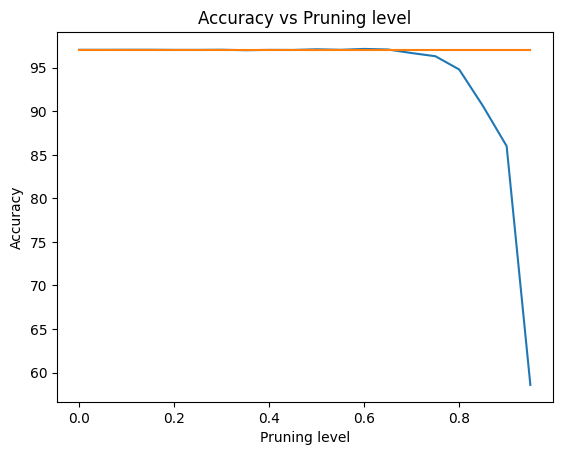

In [76]:
# Display the accuracy
plt.plot(1/20 * np.arange(20), list_accuracy_weight)
plt.plot(1/20 * np.arange(20), list_accuracy_neurons)
plt.xlabel('Pruning level')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Pruning level')
plt.show()